<a href="https://colab.research.google.com/github/oconcito8/deeplearningextraordinaria/blob/main/PROYECTOFINALNEURALSTYLETRANSFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Práctica Final Neural Style Transfer con dos imagenes de estilo


GRUPO: A08

CARLOS OCON GARAY.

PEDRO GARCIA SILGO

En este proyecto de transferencia de estilo neuronal, aplicaremos dos estilos artísticos diferentes a una imagen base utilizando técnicas de deep learning. Las imágenes utilizadas en este experimento son las siguientes:

Imagen Base: Una fotografía de un conjunto de rascacielos en un entorno urbano.
Imágenes de Estilo: Dos imágenes representativas de movimientos artísticos:
Una imagen que refleja el expresionismo.
Otra imagen que refleja el pop art.
El objetivo es combinar las características estilísticas de ambas imágenes de estilo y aplicarlas a la imagen base, creando una nueva imagen que conserve la estructura y el contenido de la fotografía original pero que exhiba una fusión de los elementos visuales distintivos del expresionismo y el pop art.

Este código implementa el algoritmo de transferencia de estilo utilizando una red neuronal convolucional preentrenada (VGG19) para extraer características de las imágenes. El proceso de transferencia de estilo se realiza optimizando una función de pérdida que equilibra la conservación del contenido de la imagen base y la incorporación de los estilos combinados de las imágenes de referencia

---



# Librerías necesarias para la ejecución.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import keras

# Carga y Preprocesamiento de Imágenes para el Modelo VGG19

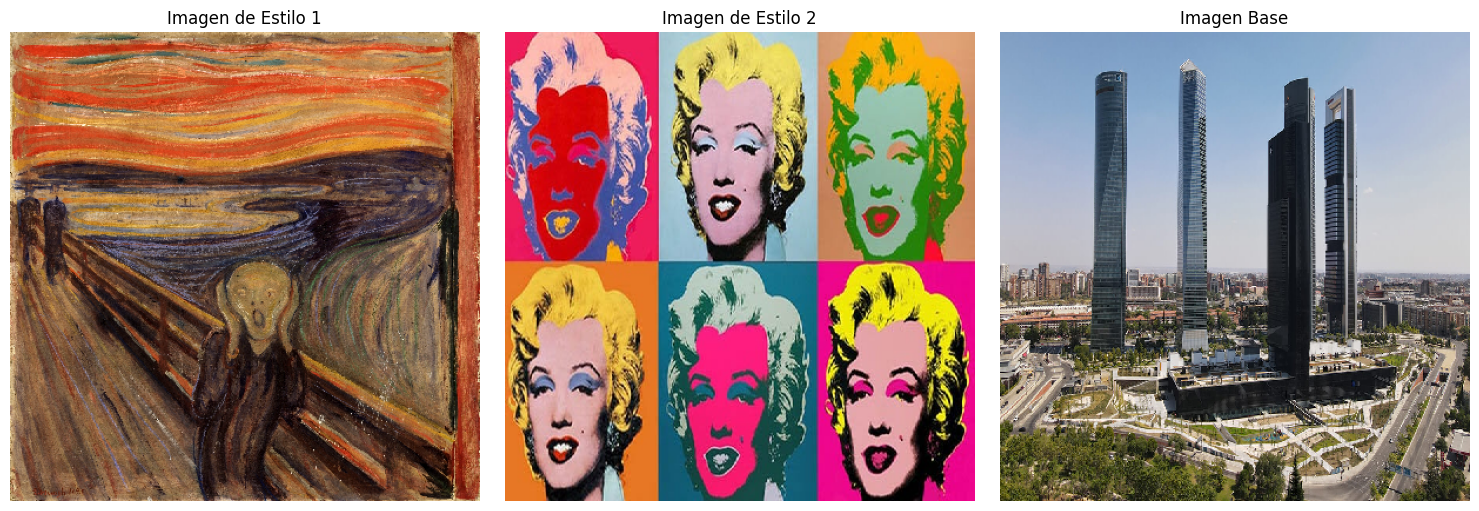

In [ ]:
# Dimensiones de la imagen
img_height, img_width = 400, 400

# Cargar imágenes
base_image_path = 'fotobase1.jpeg'
style_image_path1 = 'estilo1.png'
style_image_path2 = 'estilo2.jpeg'

# Cargar y preprocesar la imagen
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))  # Carga la imagen y la redimensiona
    img = img_to_array(img)  # Convierte la imagen a un array de NumPy
    img = np.expand_dims(img, axis=0)  # Añade una dimensión adicional para el lote
    img = vgg19.preprocess_input(img)  # Preprocesa la imagen para el modelo VGG19
    return tf.convert_to_tensor(img)

# Deprocesar la imagen para visualizarla
def deprocess_image(img):
    x = img.numpy().reshape((img_height, img_width, 3))  # Reconfigura el array a las dimensiones originales
    x[:, :, 0] += 103.939  # Desnormaliza el canal R
    x[:, :, 1] += 116.779  # Desnormaliza el canal G
    x[:, :, 2] += 123.68   # Desnormaliza el canal B
    x = x[:, :, ::-1]  # Convierte de BGR a RGB
    x = np.clip(x, 0, 255).astype('uint8')  # Asegura que los valores están en el rango correcto
    return x

# Cargar y preprocesar las imágenes de estilo y la imagen base
style_image1 = load_and_process_image(style_image_path1)  # Carga y preprocesa la primera imagen de estilo
style_image2 = load_and_process_image(style_image_path2)  # Carga y preprocesa la segunda imagen de estilo
base_image = load_and_process_image(base_image_path)      # Carga y preprocesa la imagen base

# Deprocesar las imágenes para visualizarlas
style_image1_deprocessed = deprocess_image(style_image1[0])
style_image2_deprocessed = deprocess_image(style_image2[0])
base_image_deprocessed = deprocess_image(base_image[0])

# Mostrar las imágenes de estilo y la imagen base
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(style_image1_deprocessed)
plt.title("Imagen de Estilo 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_image2_deprocessed)
plt.title("Imagen de Estilo 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(base_image_deprocessed)
plt.title("Imagen Base")
plt.axis('off')

plt.tight_layout()
plt.show()



#Deprocesamiento de Imágenes para Visualización

In [ ]:
# Deprocesar la imagen para visualizarla
def deprocess_image(img):
    x = img.reshape((img_height, img_width, 3))  # Reconfigura el array a las dimensiones originales
    x[:, :, 0] += 103.939  # Desnormaliza el canal R
    x[:, :, 1] += 116.779  # Desnormaliza el canal G
    x[:, :, 2] += 123.68   # Desnormaliza el canal B
    x = x[:, :, ::-1]  # Convierte de BGR a RGB
    x = np.clip(x, 0, 255).astype('uint8')  # Asegura que los valores están en el rango correcto
    return x


In [ ]:
# Definir el modelo VGG19
model = vgg19.VGG19(weights="imagenet", include_top=False)  # Carga el modelo VGG19 sin las capas superiores
feature_extractor = keras.Model(inputs=model.inputs, outputs={layer.name: layer.output for layer in model.layers})  # Crea un extractor de características

# Funciones de pérdida
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))  # Calcula la pérdida de contenido como la media de las diferencias cuadráticas

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)  # Calcula la matriz de Gram
    factor = tf.cast(tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2], tf.float32)  # Factor de normalización
    return result / factor

def style_loss(style, gram_target):
    gram_style = gram_matrix(style)  # Calcula la matriz de Gram del estilo
    return tf.reduce_mean(tf.square(gram_style - gram_target))  # Calcula la pérdida de estilo


##Definición del Modelo VGG19

Se carga el modelo VGG19 preentrenado en el conjunto de datos ImageNet, excluyendo las capas superiores de clasificación. Además, se crea un extractor de características que produce un diccionario con las salidas de todas las capas del modelo, lo cual es útil para calcular las pérdidas de contenido y estilo.

## Funciones de Pérdida

**Pérdida de Contenido**: Calcula la media de las diferencias cuadráticas entre las características del contenido base y el objetivo, evaluando cuán similar es el contenido generado al original.

**Matriz de Gram y Pérdida de Estilo**: La matriz de Gram captura las correlaciones de estilo en una imagen. La pérdida de estilo se calcula como la media de las diferencias cuadráticas entre la matriz de Gram del estilo de la imagen generada y la del objetivo, evaluando cuán similar es el estilo generado al original.

Estas funciones de pérdida son esenciales para comparar y transferir las características de contenido y estilo entre imágenes, permitiendo la creación de nuevas imágenes que combinan el contenido de una imagen con el estilo de otra.

# Carga, Preprocesamiento y Extracción de Características de Imágenes para Transferencia de Estilo

In [ ]:
base_image = load_and_process_image(base_image_path)  # Carga y preprocesa la imagen base
style_image1 = load_and_process_image(style_image_path1)  # Carga y preprocesa la primera imagen de estilo
style_image2 = load_and_process_image(style_image_path2)  # Carga y preprocesa la segunda imagen de estilo

# Obtener características
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Capas de estilo
content_layer = 'block5_conv2'  # Capa de contenido
base_content_features = feature_extractor(base_image)[content_layer]  # Extrae características de contenido
style_features1 = {layer: feature_extractor(style_image1)[layer] for layer in style_layers}  # Extrae características de estilo de la primera imagen
style_features2 = {layer: feature_extractor(style_image2)[layer] for layer in style_layers}  # Extrae características de estilo de la segunda imagen

# Combinación de Características de Estilo y Configuración para Optimización en Transferencia de Estilo

In [ ]:
# Combinar características de estilo
combined_style_features = {layer: (style_features1[layer] + style_features2[layer]) / 2.0 for layer in style_layers}  # Promedia las características de estilo
target_style_grams = {layer: gram_matrix(features) for layer, features in combined_style_features.items()}  # Calcula las matrices de Gram

# Optimización
optimizer = tf.optimizers.Adam(learning_rate=10.0)  # Configura el optimizador Adam
combination_image = tf.Variable(base_image)  # La imagen combinada se inicializa como la imagen base

# Implementación y Ejecución de la Transferencia de Estilo Utilizando Pérdida de Contenido y Estilo

Iteration 0


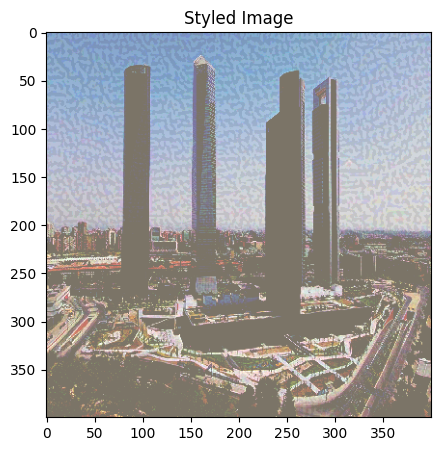

Iteration 10


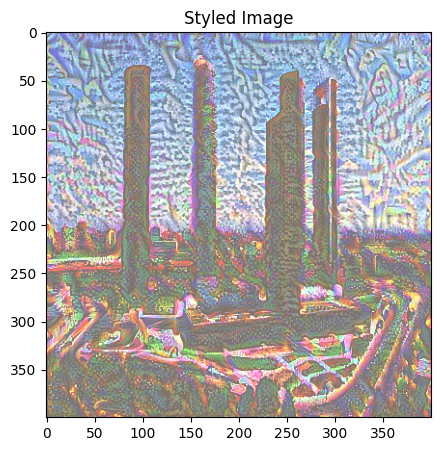

Iteration 20


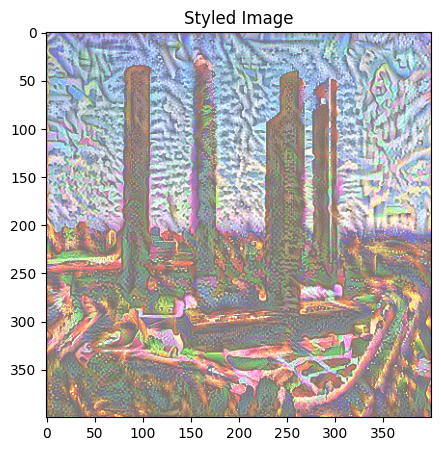

Iteration 30


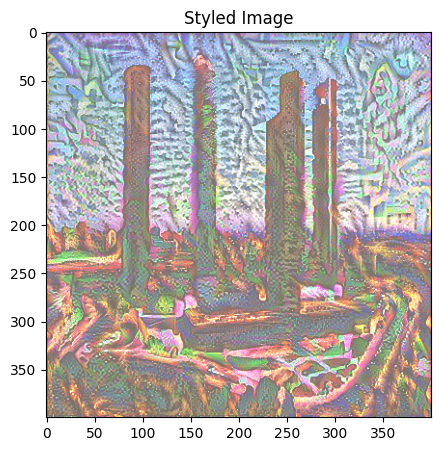

Iteration 40


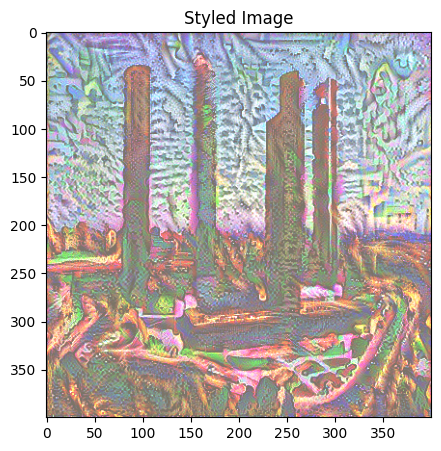

Iteration 50


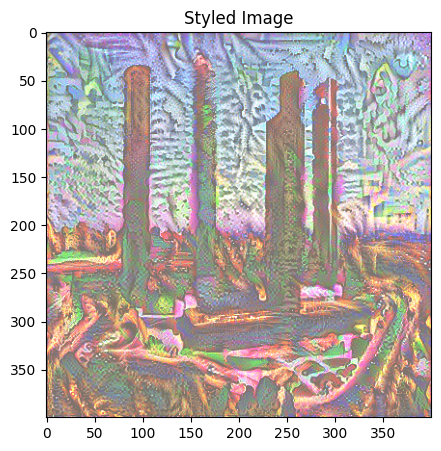

Iteration 60


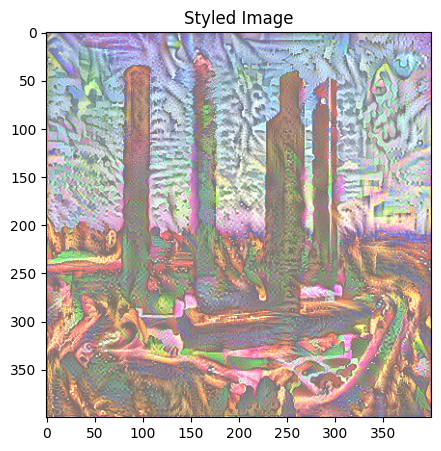

Iteration 70


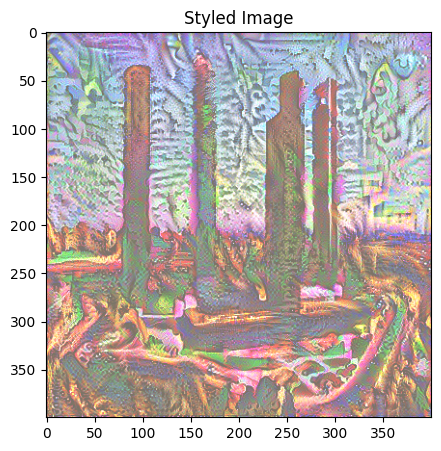

Iteration 80


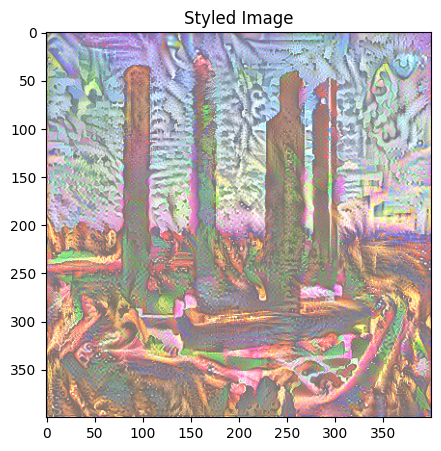

Iteration 90


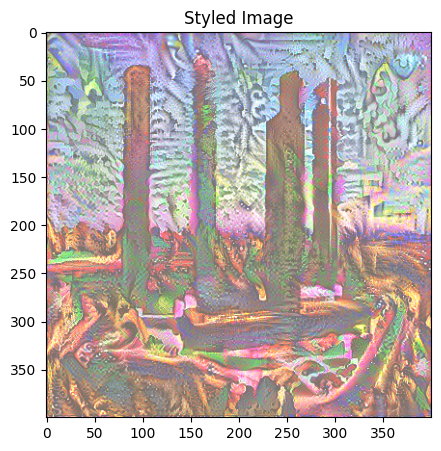

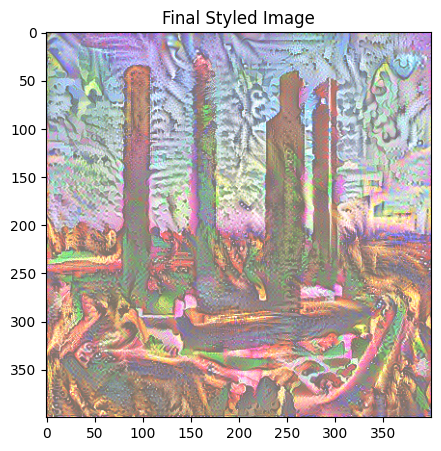

In [ ]:
# Paso de entrenamiento
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        output_features = feature_extractor(image)  # Extrae características de la imagen combinada
        loss = content_loss(output_features[content_layer], base_content_features)  # Calcula la pérdida de contenido
        for layer, gram_target in target_style_grams.items():
            loss += style_loss(output_features[layer], gram_target) * (1.0 / len(style_layers))  # Añade la pérdida de estilo
        loss += tf.image.total_variation(image) * 1e-6  # Añade la pérdida de variación total
    grads = tape.gradient(loss, image)  # Calcula los gradientes
    optimizer.apply_gradients([(grads, image)])  # Aplica los gradientes
    image.assign(tf.clip_by_value(image, 0.0, 255.0))  # Clipa los valores de la imagen combinada

# Ejecutar la transferencia de estilo
iterations = 100
for i in range(iterations):
    train_step(combination_image)  # Realiza un paso de entrenamiento
    if i % 10 == 0:
        print(f"Iteration {i}")
        plt.figure(figsize=(10, 5))
        plt.imshow(deprocess_image(combination_image.numpy()))  # Muestra la imagen estilizada
        plt.title("Styled Image")
        plt.show()

# Mostrar el resultado final
plt.figure(figsize=(10, 5))
plt.imshow(deprocess_image(combination_image.numpy()))  # Muestra la imagen estilizada final
plt.title("Final Styled Image")
plt.show()


### Conclusión

La transferencia de estilo que combina elementos del Expresionismo, específicamente de "El Grito" de Edvard Munch, y el Pop Art de la serie Marilyn de Andy Warhol, sobre una foto base de las cuatro torres de Madrid, ha producido un resultado fascinante y visualmente impactante.

#### Análisis de los Estilos Combinados

1. **Expresionismo de "El Grito" de Edvard Munch**:
   - El Expresionismo de Munch es conocido por sus líneas onduladas y vibrantes, así como por los colores intensos y emotivos. Estas características crean una sensación de movimiento y angustia.
   - En la imagen generada, podemos observar cómo estos elementos expresionistas aportan una textura emocional y dramática a las torres, transformando la estructura rígida y moderna en algo más orgánico y vivo.

2. **Pop Art de la Serie Marilyn de Andy Warhol**:
   - El Pop Art de Warhol es famoso por su uso de colores brillantes y contrastantes, así como por la repetición de patrones y elementos gráficos.
   - La imagen generada muestra influencias del Pop Art en el uso de colores saturados y la aplicación de patrones llamativos, que aportan una vibración contemporánea y llamativa a la fotografía de las torres.

El resultado de esta mezcla estilística es una imagen que trasciende la realidad arquitectónica de las cuatro torres de Madrid, infundiéndolas con una energía emocional intensa y un atractivo visual audaz. Las torres se convierten en un lienzo dinámico donde el drama del Expresionismo y la vivacidad del Pop Art se fusionan para crear una obra de arte única.
